[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Neural-Networks-Machine-Learning/blob/master/Logistic-Regression/LogisticRegressionGradDescent.ipynb)

## Logistic Regression using Gradient Descent
#### By Gregory Glickert

### The first thing we need to do is get some data generated


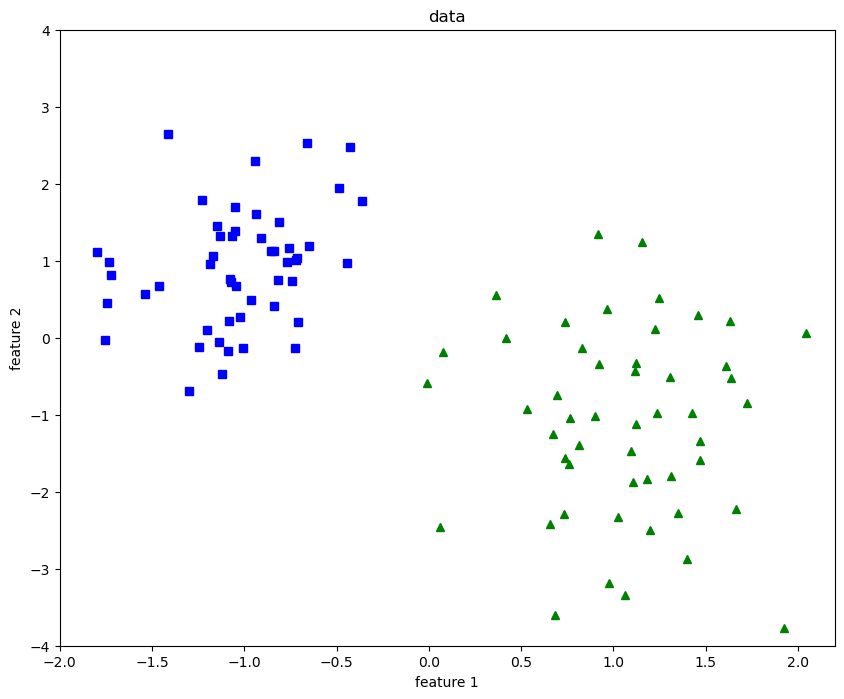

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

X, y = make_classification(n_features=2, n_redundant=0, 
                           n_informative=2, random_state=8, 
                           n_clusters_per_class=1)

fig = plt.figure(figsize=(10,8))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("data")
xmin, xmax = -2, 2.2
ymin, ymax = -4, 4
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.show()

### Why Logistic Regression?

In Linear Regression, we try to predict a continuous value. However, in **Classification**, we want to predict a discrete label (e.g., 0 or 1). 

If we used a straight line (Linear Regression) for classification, the output could be anything from $-\infty$ to $+\infty$. This doesn't make sense for probabilities, which must be between 0 and 1.

### The Sigmoid Function

To solve this, we use the **Sigmoid function** (also called the Logistic function). it "squashes" any real-valued number into the range [0, 1].

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

When $z$ is a large positive number, $\sigma(z) \approx 1$.
When $z$ is a large negative number, $\sigma(z) \approx 0$.
When $z = 0$, $\sigma(z) = 0.5$.

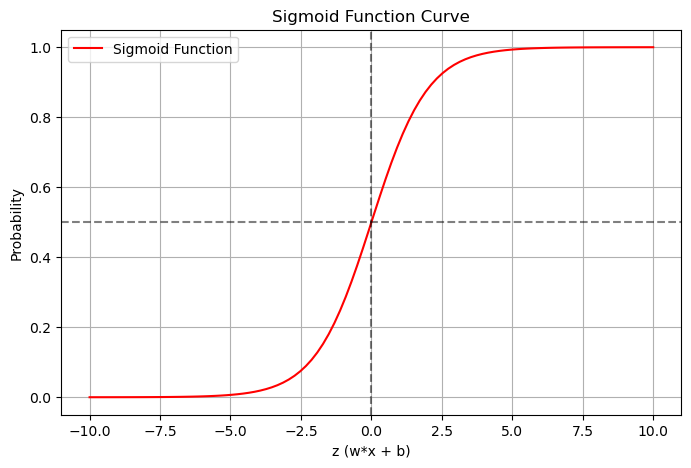

In [2]:
# Let's visualize the Sigmoid function
def sigmoid_plot(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 100)
plt.figure(figsize=(8, 5))
plt.plot(z, sigmoid_plot(z), 'r', label='Sigmoid Function')
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.title("Sigmoid Function Curve")
plt.xlabel("z (w*x + b)")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()

### Decision Threshold

In logistic regression, the output is a probability. To make a final classification (0 or 1), we use a **threshold** (usually 0.5):

- If $\hat{y} \ge 0.5$, predict Class 1.
- If $\hat{y} < 0.5$, predict Class 0.

Since sigmoid(z) = 0.5 when $z=0$, this means we predict Class 1 when $w \cdot x + b \ge 0$. The line $w \cdot x + b = 0$ is called the **Decision Boundary**.


## Explanation of the `predict` Function

The `predict` function computes the predicted probability $\hat{y}$ for a given input $x$ and model parameters $w$ (weights) and $b$ (bias):

$$
\hat{y} = \frac{1}{1 + e^{-(w \cdot x + b)}}
$$


In [3]:
# Logistic function (sigmoid)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Predict function using the sigmoid function
def predict(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)


### Binary Cross Entropy (Log-Loss)

We use **Binary Cross Entropy** as the loss function instead of Mean Squared Error (MSE) for two main reasons:

1.  **Convexity**: When used with the sigmoid function, MSE results in a non-convex cost function with many local minima, making it hard for Gradient Descent to find the global minimum. Log-Loss is convex, ensuring a single global minimum.
2.  **Penalty**: Log-loss heavily penalizes "confident and wrong" predictions. 
    - If the true label is $y=1$ and the model predicts $\hat{y}=0.01$, the loss is very high.
    - If the model predicts $\hat{y}=0.99$, the loss is near zero.

$$
J(w, b) = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Where $n$ is the number of samples, $y_i$ is the actual label, and $\hat{y}_i$ is the probability predicted by the sigmoid function.
- $\hat{y}_i$ is the predicted probability for the \(i\)-th data point.



In [4]:
# Compute cross-entropy loss
def compute_cost(X, y, w, b):
    m = len(y)
    predictions = predict(X, w, b)
    cost = -1/m * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost


### The Decision Boundary

The **Decision Boundary** is the line (or hyperplane in higher dimensions) that separates the different classes. In our case, with two features, it is a straight line.

How do we find it?
1. The model outputs a probability $\hat{y} = \sigma(z)$.
2. We typically use a **threshold of 0.5** to decide the class:
   - If $\sigma(z) \ge 0.5$, we predict class 1.
   - If $\sigma(z) < 0.5$, we predict class 0.
3. The boundary occurs exactly where $\sigma(z) = 0.5$.
4. Since $\sigma(z) = \frac{1}{1 + e^{-z}}$, then $\sigma(z) = 0.5$ when $z = 0$.
5. For two features $x_1$ and $x_2$, our linear combination is:
   $$z = w_1 x_{1} + w_2 x_{2} + b$$
6. Setting $z = 0$:
   $$w_1 x_{1} + w_2 x_{2} + b = 0$$
7. Solving for $x_2$ (which is our y-axis in the plot):
   $$x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2}$$

This is the equation of the line $y = mx + c$ where the slope $m = -w_1/w_2$ and the intercept $c = -b/w_2$.

In [5]:
def find_boundary(w, b, x_min, x_max):
    # The decision boundary is where w0*x + w1*y + b = 0
    # So y = (-w0*x - b) / w1
    m = -w[0]/w[1]
    c = -b/w[1]
    xd = np.array([x_min, x_max])
    yd = m * xd + c
    return xd, yd

### Gradient Descent

**Gradient Descent** is an iterative optimization algorithm used to minimize the cross-entropy loss function in logistic regression. The update rules for the parameters during each iteration are:

$$
w := w - \alpha \cdot \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i) \cdot x_i
$$

$$
b := b - \alpha \cdot \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)
$$

Where:
- $\alpha$ is the learning rate,
- $n$ is the number of data points,
- $x_i$ and $y_i$ are the individual data points.


In [6]:
# Gradient descent function
def gradient_descent(X, y, w_init, b_init, learning_rate, n_iterations, show_progress=True):
    w = w_init.copy()
    b = b_init
    m = len(y)
    cost_history = []
    
    # Calculate limits for plotting based on the data
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    for iteration in range(n_iterations):
        # Log model prediction
        predictions = predict(X, w, b)
        
        # Gradients
        dw = (1/m) * np.dot(X.T, (predictions - y))
        db = (1/m) * np.sum(predictions - y)
        
        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db
        
        # Compute and store cost
        cost_history.append(compute_cost(X, y, w, b))
        
        # Show progress at specific intervals
        if show_progress and (iteration == 0 or iteration == n_iterations // 2 or iteration == n_iterations - 1):
            print(f"Iteration {iteration}: Cost = {cost_history[-1]}")
            xd, yd = find_boundary(w, b, x_min, x_max)

            plt.figure(figsize=(8, 6))
            plt.plot(xd, yd, 'k', lw=2, label='Decision Boundary')
            
            # Shading the classification regions
            plt.fill_between(xd, yd, y_min, color='green', alpha=0.1, label='Class 0 Region')
            plt.fill_between(xd, yd, y_max, color='blue', alpha=0.1, label='Class 1 Region')
            
            plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='g', marker='^', label='Class 0')
            plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='s', label='Class 1')
            
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.title(f"Logistic Regression Iteration {iteration}")
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()
            
    return w, b, cost_history


Iteration 0: Cost = 0.6465339490082839


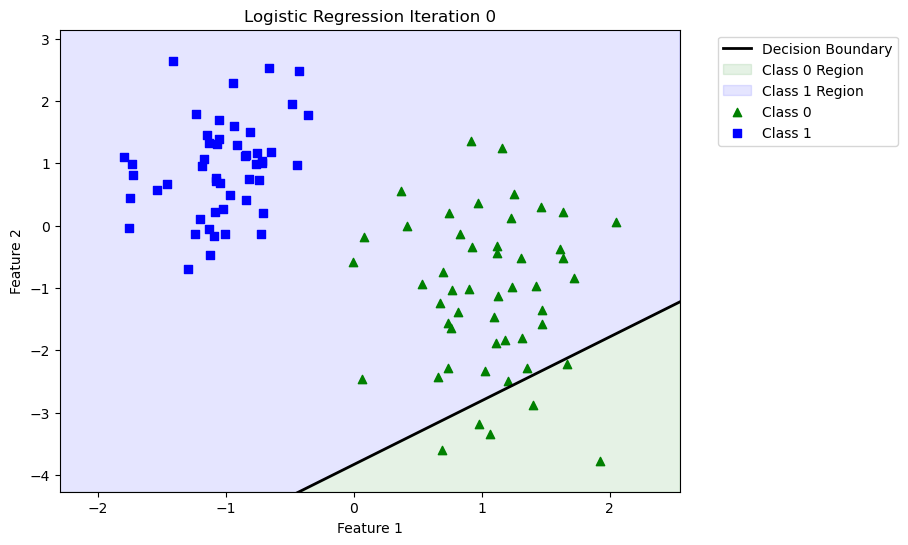

Iteration 100: Cost = 0.10291826615741054


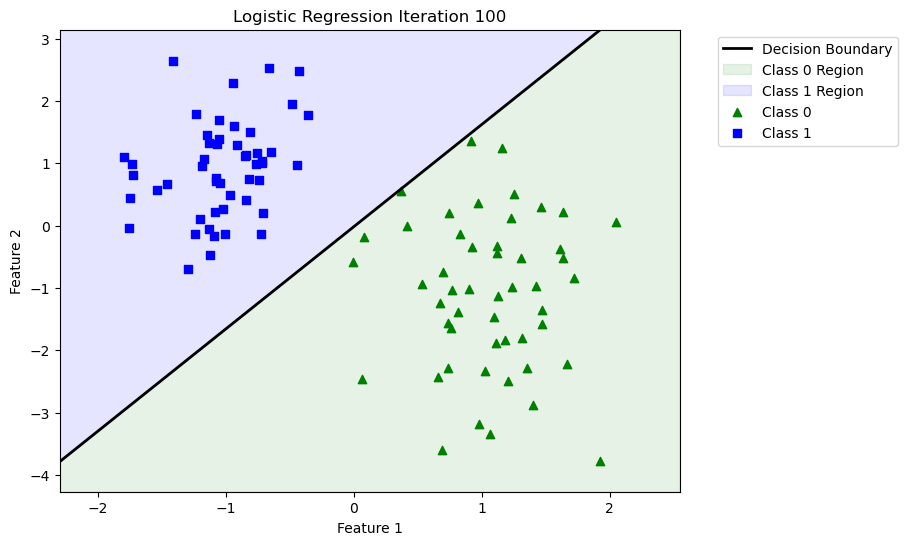

Iteration 199: Cost = 0.06491172682402317


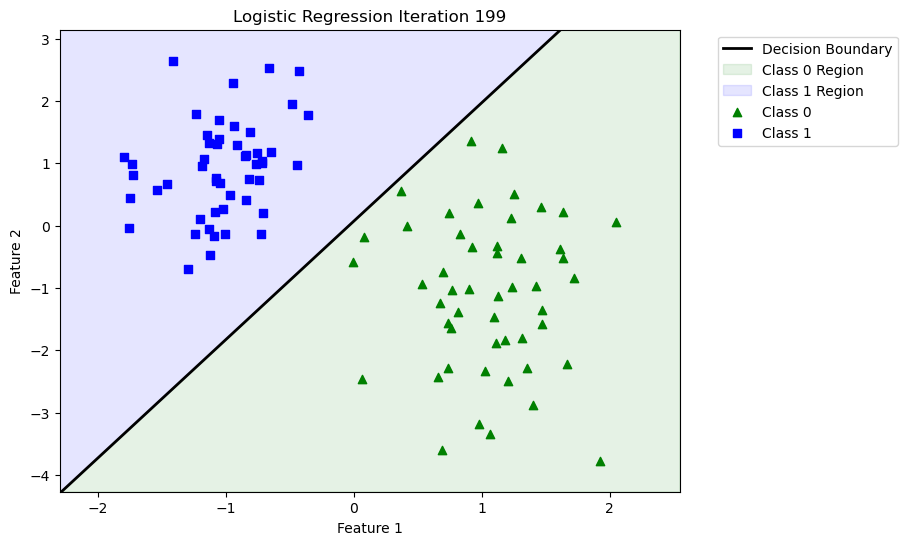

In [7]:
# Initialize parameters
w_init = np.zeros(X.shape[1])  # Initial weight vector
b_init = 0.2  # Initial bias term
learning_rate = 0.1
n_iterations = 200
show_progress = True  # Set to True if you want to see the progress during training

# Perform gradient descent to find the optimal weights and bias
optimal_w, optimal_b, cost_history = gradient_descent(X, y, w_init, b_init, learning_rate, n_iterations, show_progress)


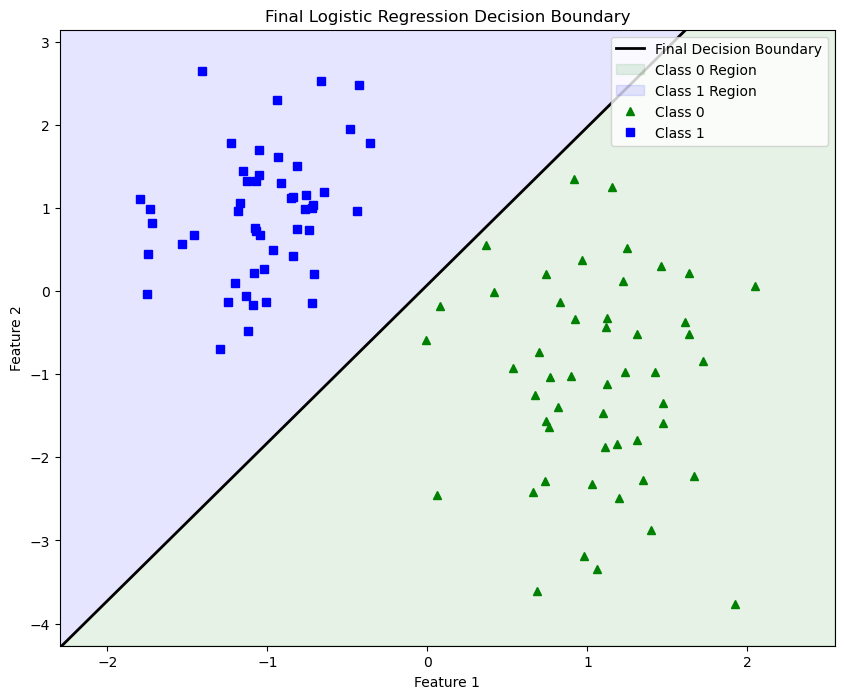

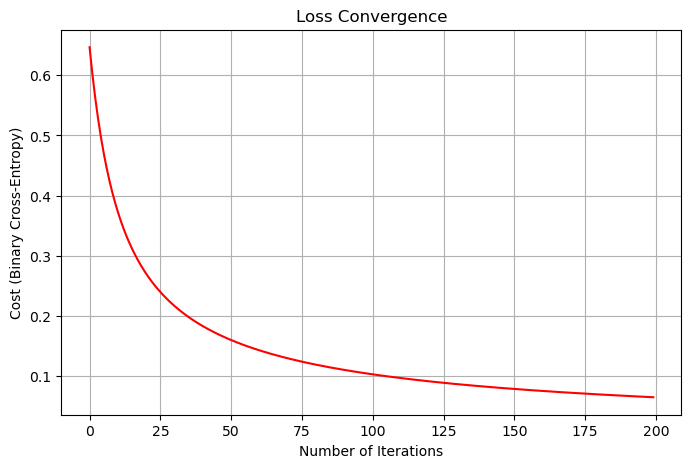

Final weights: [-2.27121    1.1951296]
Final bias: -0.08798099971336912


In [8]:
# Plotting the final decision boundary
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xd, yd = find_boundary(optimal_w, optimal_b, x_min, x_max)

plt.figure(figsize=(10, 8))
plt.plot(xd, yd, 'k', lw=2, label='Final Decision Boundary')
plt.fill_between(xd, yd, y_min, color='green', alpha=0.1, label='Class 0 Region')
plt.fill_between(xd, yd, y_max, color='blue', alpha=0.1, label='Class 1 Region')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^", label='Class 0')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label='Class 1')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Final Logistic Regression Decision Boundary")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# Plot the cost history
plt.figure(figsize=(8, 5))
plt.plot(range(len(cost_history)), cost_history, 'r-')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (Binary Cross-Entropy)')
plt.title('Loss Convergence')
plt.grid(True)
plt.show()

# Output final weights and bias
print(f"Final weights: {optimal_w}")
print(f"Final bias: {optimal_b}")

### Probability Surface and Non-Linearity

While the decision boundary is a sharp line where $P(y=1) = 0.5$, logistic regression actually calculates a continuous probability surface across the entire feature space. 

#### 1. Confidence and Uncertainty
- **Near the Decision Boundary**: The probability is close to 0.5, meaning the model is less certain about the classification.
- **Far from the Decision Boundary**: The probability approaches 0 or 1, representing higher confidence.

#### 2. Why is the boundary linear?
The boundary $w_1 x_1 + w_2 x_2 + b = 0$ is linear because we are using a linear combination of the features. If our data were not linearly separable (like a circle of one class inside another), a standard logistic regression would fail to find an accurate boundary. To handle non-linear data, we would need to:
- Transform the features (e.g., adding $x^2$ or $x_1 x_2$ terms).
- Use multiple layers of neurons (Neural Networks), which can learn these non-linear transformations automatically.

Below is a visualization of the **Probability Surface** (or Heat Map). It shows the transition from Class 0 (green) to Class 1 (blue) across the feature space.

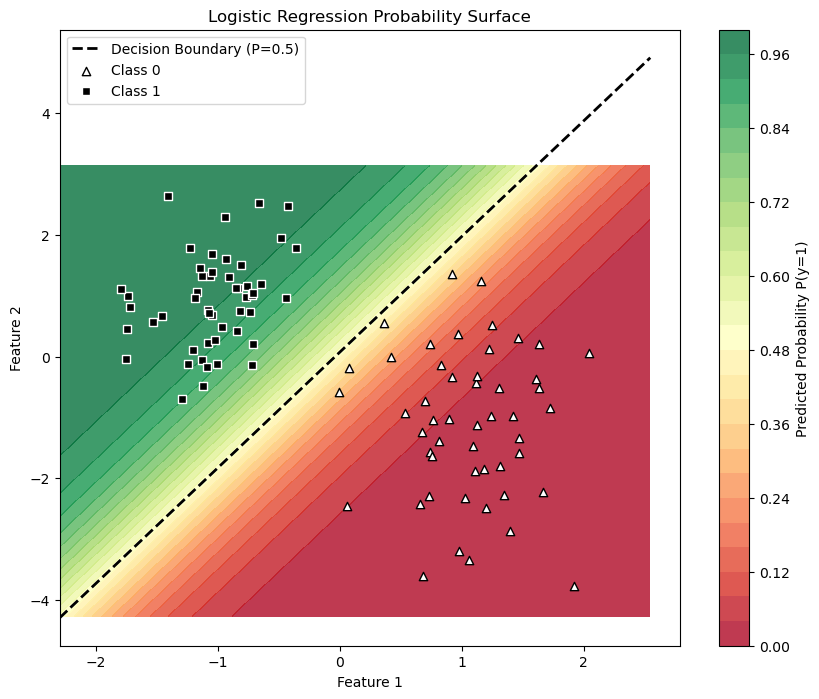

In [9]:
# Visualization of the Probability Surface
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict probabilities for every point in the mesh
grid_points = np.c_[xx.ravel(), yy.ravel()]
probs = predict(grid_points, optimal_w, optimal_b)
probs = probs.reshape(xx.shape)

plt.figure(figsize=(10, 8))
# Use a color mesh to show the probability surface
contour = plt.contourf(xx, yy, probs, 25, cmap="RdYlGn", alpha=0.8)
plt.colorbar(contour, label='Predicted Probability P(y=1)')

# Plot the decision boundary line
xd, yd = find_boundary(optimal_w, optimal_b, x_min, x_max)
plt.plot(xd, yd, 'k--', lw=2, label='Decision Boundary (P=0.5)')

# Plot the original data points
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='white', edgecolors='k', marker='^', label='Class 0')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='black', edgecolors='w', marker='s', label='Class 1')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Probability Surface")
plt.legend()
plt.show()